In [2]:
# ps. I own an AMD GPU which couldn't be used with tensorflow.keras
# plaidml allows AMD GPUs to be used for training in keras 
# if you own a nvidia GPU you can always enable keras with tensorflow and CUDA
# bascially training image machine learning models with GPUs is much faster
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras


Using plaidml.keras.backend backend.


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dense, Flatten
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

import cv2

from PIL import Image

Data can be downloaded from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [4]:
# 25,000 images in our training set
len(os.listdir('./train'))

25000

In [5]:
# all files are jpg
os.listdir('./train')[:10]

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

In [6]:
os.listdir('./train')[-10:]
# file names are standardized and labelled as cat or dog + running index

['dog.9990.jpg',
 'dog.9991.jpg',
 'dog.9992.jpg',
 'dog.9993.jpg',
 'dog.9994.jpg',
 'dog.9995.jpg',
 'dog.9996.jpg',
 'dog.9997.jpg',
 'dog.9998.jpg',
 'dog.9999.jpg']

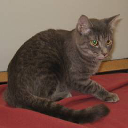

In [7]:
# showing an image as a check
img = image.load_img(os.path.join('./train', os.listdir('./train')[3737]), target_size=(128, 128), color_mode='rgb')
img

### Preprocessing Data
**Convert data into dataframe**

In [8]:
# label 1 for dog, 0 for cat
label = []
for file in os.listdir('./train'):
    if file.split('.')[0] == 'dog':
        label.append(str(1))
    else:
        label.append(str(0))

# converting file and labels into dataframe
df = pd.DataFrame({'filename': os.listdir('./train'), 'label': label})

In [9]:
# dataset is evenly split
df['label'].value_counts(normalize=True)

0    0.5
1    0.5
Name: label, dtype: float64

In [10]:
# split into train and validation set
train_df, valid_df = train_test_split(df, test_size=0.2, stratify = df['label'], random_state=37)

In [11]:
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


In [12]:

# We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(rescale=1./255)

# create flow to generate mini-batches
train_gen = train_datagen.flow_from_dataframe(train_df, directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (128, 128),
                                              batch_size = 64, 
                                              class_mode='binary')


valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (128, 128),
                                              batch_size = 64, 
                                              class_mode='binary')


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


**1. Simple CNN model**

In [13]:
# create a simple model to test 

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, kernel_size=3, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary()

INFO:plaidml:Opening device "opencl_amd_gfx1010.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
__________

In [14]:
# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit_generator(train_gen, epochs = 20, validation_data = valid_gen)

Epoch 1/20
313/313 [==============================] - 180s 574ms/step - loss: 0.6350 - acc: 0.6302 - val_loss: 0.5743 - val_acc: 0.6978
Epoch 2/20
313/313 [==============================] - 41s 132ms/step - loss: 0.5365 - acc: 0.7295 - val_loss: 0.4958 - val_acc: 0.7598
Epoch 3/20
313/313 [==============================] - 42s 134ms/step - loss: 0.4976 - acc: 0.7550 - val_loss: 0.4869 - val_acc: 0.7686
Epoch 4/20
313/313 [==============================] - 41s 130ms/step - loss: 0.4261 - acc: 0.8028 - val_loss: 0.4267 - val_acc: 0.7944
Epoch 5/20
313/313 [==============================] - 41s 131ms/step - loss: 0.3836 - acc: 0.8261 - val_loss: 0.4114 - val_acc: 0.8194
Epoch 6/20
313/313 [==============================] - 41s 132ms/step - loss: 0.3099 - acc: 0.8633 - val_loss: 0.4106 - val_acc: 0.8232
Epoch 7/20
313/313 [==============================] - 41s 131ms/step - loss: 0.2599 - acc: 0.8897 - val_loss: 0.5053 - val_acc: 0.7834
Epoch 8/20
313/313 [==============================] - 

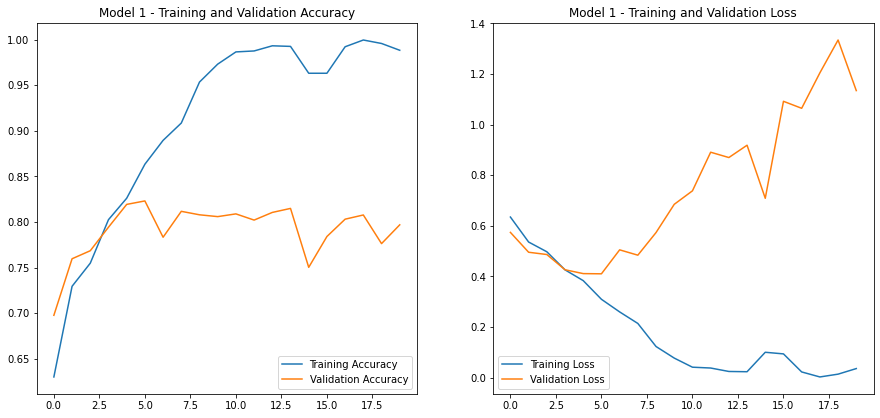

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model 1 - Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Model 1 - Training and Validation Loss')
plt.show()

**2. CNN model with data augmenting and dropouts**

We observed that our model is overfitted to our training set. To try and remedy that, we add some dropouts to our model and also augment our training dataset to see if our validation accuracy improves and make our model less over-fitted. 
<br>

To learn more about data augmentation, see a basic introduction [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/):

In [27]:
# augmenting our training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zca_whitening=False,
                                  rotation_range = 30,
                                  zoom_range = 0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip = True,
                                  fill_mode='constant')

#flow_from_dataframe() method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (128, 128),
                                              batch_size = 64, 
                                              class_mode='binary')

# similarly, we do not augment validation data.
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (128, 128),
                                              batch_size = 64, 
                                              class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [28]:
# adding dropouts 

model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(128,128,3)))
model_2.add(MaxPooling2D())
model_2.add(Dropout(0.3))

model_2.add(Conv2D(64, kernel_size=3, activation="relu"))
model_2.add(MaxPooling2D())
model_2.add(Dropout(0.3))

model_2.add(Conv2D(128, kernel_size=3, activation="relu"))
model_2.add(MaxPooling2D())
model_2.add(Dropout(0.3))

model_2.add(Flatten())
model_2.add(Dense(128,activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
__________

In [29]:
# compiling the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history_2 = model_2.fit_generator(train_gen, epochs = 20, validation_data = valid_gen)

Epoch 1/20
313/313 [==============================] - 150s 478ms/step - loss: 0.6837 - acc: 0.5578 - val_loss: 0.6577 - val_acc: 0.5884
Epoch 2/20
313/313 [==============================] - 88s 281ms/step - loss: 0.6350 - acc: 0.6285 - val_loss: 0.5915 - val_acc: 0.6932
Epoch 3/20
313/313 [==============================] - 90s 286ms/step - loss: 0.5927 - acc: 0.6764 - val_loss: 0.5344 - val_acc: 0.7324
Epoch 4/20
313/313 [==============================] - 88s 281ms/step - loss: 0.5594 - acc: 0.7111 - val_loss: 0.5082 - val_acc: 0.7522
Epoch 5/20
313/313 [==============================] - 88s 281ms/step - loss: 0.5255 - acc: 0.7313 - val_loss: 0.4713 - val_acc: 0.7746
Epoch 6/20
313/313 [==============================] - 88s 280ms/step - loss: 0.5096 - acc: 0.7501 - val_loss: 0.4751 - val_acc: 0.7666
Epoch 7/20
313/313 [==============================] - 88s 281ms/step - loss: 0.4836 - acc: 0.7668 - val_loss: 0.4239 - val_acc: 0.8030
Epoch 8/20
313/313 [==============================] - 

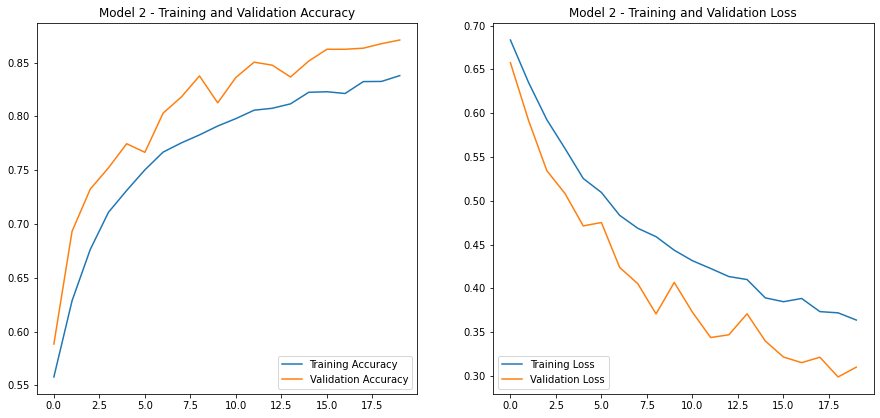

In [31]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model 2 - Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Model 2 - Training and Validation Loss')
plt.show()

Our second model performed significantly better in terms of accuracy gains as well as not overfitting the validation set, hence it generalized better. Should we continue to train for more epochs, the accuracy perhaps can improved slightly further, however from the chart, it seems that breaking the 90% accuracy threshold might be difficult.  
<br>
Is that the best we could do? Recall our model was just a simple neural network model with only a few layers. In our third attempt, let's try transfer learning. Transfer learning essentially is taking a pre-trained model that was specificially built and optimized for a certain problem and using it to solve a related problem. For our situation, we can use a pre-trained model that was specially built to classify and identify images and use it in our situation. An example is ResNet50, which is a convolutional neural network that is 50 layers deep and trained to classify images into 1000 object categories. 

Of course, using ResNet50 would be an 'overkill' in our situation, but let's try to see what the accuracy will be like:


**3. Transfer Learning using ResNet50**

In [39]:
# import ResNet50
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

model_3 = Sequential()
model_3.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model_3.add(Dense(1, activation = 'sigmoid'))

model_3.layers[0].trainable = False 



In [40]:
# ResNet has its own way to preprocess data, hence we use that
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  zca_whitening=False,
                                  rotation_range = 30,
                                  zoom_range = 0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip = True,
                                  fill_mode='constant')

#flow_from_dataframe() method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (128,128),
                                              batch_size = 64, 
                                              class_mode='binary')

# similarly, we do not augment validation data.
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (128,128),
                                              batch_size = 64, 
                                              class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [41]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
model_3.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')

In [43]:
history_3 = model_3.fit_generator(train_gen, epochs = 20, validation_data = valid_gen)

Epoch 1/20
313/313 [==============================] - 94s 302ms/step - loss: 0.5145 - acc: 0.8445 - val_loss: 0.2402 - val_acc: 0.9510
Epoch 2/20
313/313 [==============================] - 92s 293ms/step - loss: 0.3522 - acc: 0.8833 - val_loss: 0.2120 - val_acc: 0.9536
Epoch 3/20
313/313 [==============================] - 91s 292ms/step - loss: 0.2991 - acc: 0.8940 - val_loss: 0.2799 - val_acc: 0.9416
Epoch 4/20
313/313 [==============================] - 91s 291ms/step - loss: 0.2907 - acc: 0.8968 - val_loss: 0.2027 - val_acc: 0.9540
Epoch 5/20
313/313 [==============================] - 90s 286ms/step - loss: 0.2503 - acc: 0.9070 - val_loss: 0.2057 - val_acc: 0.9518
Epoch 6/20
313/313 [==============================] - 88s 283ms/step - loss: 0.2488 - acc: 0.9056 - val_loss: 0.1851 - val_acc: 0.9544
Epoch 7/20
313/313 [==============================] - 89s 283ms/step - loss: 0.2822 - acc: 0.8985 - val_loss: 0.2205 - val_acc: 0.9492
Epoch 8/20
313/313 [==============================] - 8

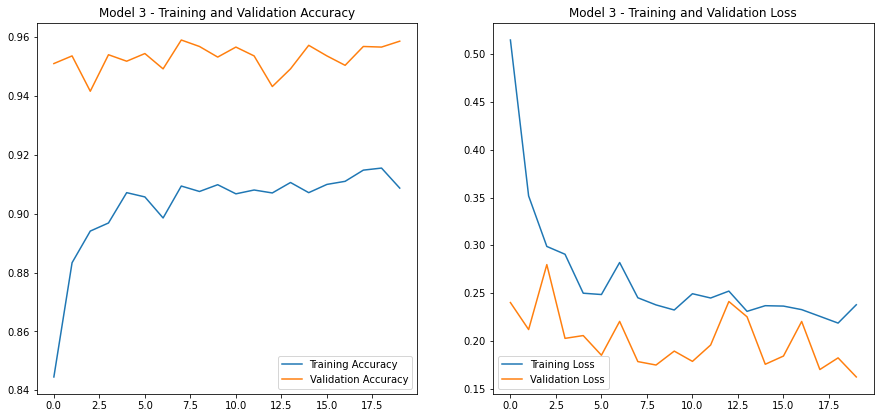

In [44]:
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model 3 - Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Model 3 - Training and Validation Loss')
plt.show()

It is no surprise that the ResNet50 model has performed so well, about 12 percentage points more than our earlier models, as ResNet has been optimized for such classification problems.  
<br>

Other popular pre-train models for image classification includes VGG-16, Inceptionv3 as well as EfficientNet. 

**4. Generating predictions based on original photos**

We could also feed ResNet our original photos and see what it predicts after training it in our problem: 

In [68]:
def predict_img(img_path, image_h=128, image_w=128):
    img = image.load_img(img_path, target_size=(image_h, image_w))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    prob = model_3.predict(x)
    prob = float(prob)
    pred = 'Dog' if prob > 0.5 else 'Cat'
    if pred == 'Cat':
        prob = 1 - prob
    print(f'The image is predicted to be: {pred} with probability={round(prob*100, 1)}%')
    return pred, prob


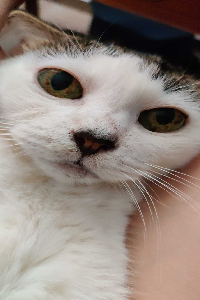

In [69]:
image.load_img(os.path.join('./img_predict/', '1.jpg'), target_size=(300, 200))

In [70]:
img_path = os.path.join('./img_predict/', '1.jpg')
predict_img(img_path)


The image is predicted to be: Cat with probability=100.0%


('Cat', 0.9996074343216605)

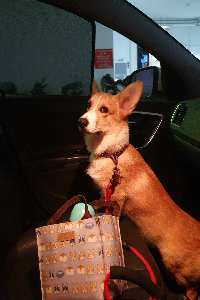

In [72]:
image.load_img(os.path.join('./img_predict/', '2.jpg'), target_size=(300, 200))

In [74]:
img_path = os.path.join('./img_predict/', '2.jpg')
predict_img(img_path)

The image is predicted to be: Dog with probability=96.7%


('Dog', 0.9671738147735596)

The model is even able to recognize incomplete pictures, like the example below which shows the paws of the cat. In fact, since our original setup was to train the model to identify between cats and dogs from the images, the model essentially looks for 'cat-ism' and 'dog-ism' features in the images and predicts based on it:

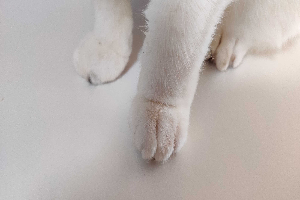

In [75]:
image.load_img(os.path.join('./img_predict/', '3.jpg'), target_size=(200, 300))

In [76]:
img_path = os.path.join('./img_predict/', '3.jpg')
predict_img(img_path)

The image is predicted to be: Cat with probability=100.0%


('Cat', 0.9999820240554982)

So, we could mischievous and feed the model an image which does not contain any cats or dogs. The model is still forced to make a prediction based on it determining whether the image contains more 'cat-ism' or 'dog-ism' features. For example, the model predicts the below image of myself as a cat! It is a relief to know that I have more cat features than dog features... 

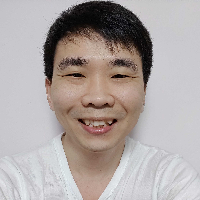

In [77]:
image.load_img(os.path.join('./img_predict/', '4.jpg'), target_size=(200, 200))

In [78]:
img_path = os.path.join('./img_predict/', '4.jpg')
predict_img(img_path)

The image is predicted to be: Cat with probability=84.7%


('Cat', 0.8467943370342255)